In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler

# Load Satellite Data

In [516]:
sites_data = pd.read_csv("~data/sites_data_11x11.csv")
sites_data

,time,lat,lon,TUR,SPM,CHL,site
0,2022-03-01,55.189352,-1.519043,NaN,NaN,NaN,Newbiggin_North
1,2022-03-01,55.189352,-1.517296,NaN,NaN,NaN,Newbiggin_North
2,2022-03-01,55.189352,-1.515549,NaN,NaN,NaN,Newbiggin_North
3,2022-03-01,55.189352,-1.513802,NaN,NaN,NaN,Newbiggin_North
4,2022-03-01,55.189352,-1.512055,NaN,NaN,NaN,Newbiggin_North
...,...,...,...,...,...,...,...
12331105,2022-10-31,50.277315,-3.893256,2.006134,1.186131,1.828091,Bigbury-on-Sea_South
12331106,2022-10-31,50.277315,-3.891509,0.708182,0.406647,1.046769,Bigbury-on-Sea_South
12331107,2022-10-31,50.277315,-3.889762,1.258156,0.729469,1.327342,Bigbury-on-Sea_South
12331108,2022-10-31,50.277315,-3.888015,1.037095,0.598882,1.254974,Bigbury-on-Sea_South


In [517]:
sites_data.isnull().sum()

time           0
lat            0
lon            0
TUR     10838900
SPM     10838900
CHL     10838900
site           0
dtype: int64

In [518]:
# Fill Null Values with 0, as we cannot have missing values in the tensors for neural network
# Later we will remove time, site pairs where all values are 0

sites_data.fillna(value=0, inplace=True)

# Load Pollution Data

In [519]:
riskforecasting = pd.read_csv('~data/pollution_risk_forecasting.csv')
riskforecasting

,Unnamed: 0,site,time,warning,riskLevelLabel
0,0,Seaton Carew North,2022-04-28,Pollution RIsk Forecasts will start soon,normal
1,1,Seaton Carew North,2022-04-29,Pollution RIsk Forecasts will start soon,normal
2,2,Seaton Carew North,2022-04-30,Pollution RIsk Forecasts will start soon,normal
3,3,Seaton Carew North,2022-05-04,No warnings in place,normal
4,4,Seaton Carew North,2022-05-05,No warnings in place,normal
...,...,...,...,...,...
63641,63641,Westward Ho!,2022-09-26,No pollution incidents reported,normal
63642,63642,Westward Ho!,2022-09-27,No pollution incidents reported,normal
63643,63643,Westward Ho!,2022-09-28,No pollution incidents reported,normal
63644,63644,Westward Ho!,2022-09-29,No pollution incidents reported,normal


# Combine Datasets to Create Input Dataset
For every site (430) and time (237), create a 11 x 11 x 3 tensor, each corresponding to one risk level label 

In [520]:
%%time
def chl_to_array(chl_values):
    # Not 100% sure if this reshapes according to lat/lon (though it does not matter if we perform the same operation every time?)
    return np.array(chl_values).reshape(11, 11)

def get_features_data(sites_data, features_list):
    '''
    input: 
        - sites_data (pd.DataFrame):
            - dataframe where each row contains feature values for a time, site and coordinate
        - features_list (list):
            - list of strings of features to use
            
    output:
        - features data (pd.DataFrame)
            - row: data for every time and site pair
            - column: features
            - entries: np.array of shape 11x11
    '''
    dfs = []
    for feature in features_list:
        df = pd.DataFrame(sites_data.groupby(['time', 'site'])[feature].apply(chl_to_array))
        dfs.append(df)
    input_data = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), dfs)
    
    return input_data

features_df = get_features_data(sites_data, ['TUR', 'SPM', 'CHL'])
features_df

CPU times: user 5.9 s, sys: 889 ms, total: 6.79 s
Wall time: 7.46 s


TUR  \
time       site                                                                        
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                              ...   
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Woolacombe_Village      [[5.9864016, 25.982555, 0.0, 0.0, 0.0, 0.0, 0....   
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                                                 SPM  \
time       site                                                                        
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                              ...   
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Woolacombe_Village      [[3.564524, 16.43204, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                                                 CHL  
time       site                                                                       
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
...                                                                              ...  
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Woolacombe_Village      [[6.564089, 6.803925, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[101910 rows x 3 columns]

In [521]:
# Naming inconsistencies

site_df = pd.read_csv("~data/site.csv")
site_df = site_df[['label', 'Site Name in Files']]
riskforecasting = riskforecasting.merge(site_df, left_on='site', right_on='label', how='left').drop(['label', 'warning'], axis=1)
riskforecasting

,Unnamed: 0,site,time,riskLevelLabel,Site Name in Files
0,0,Seaton Carew North,2022-04-28,normal,Seaton_Carew_North
1,1,Seaton Carew North,2022-04-29,normal,Seaton_Carew_North
2,2,Seaton Carew North,2022-04-30,normal,Seaton_Carew_North
3,3,Seaton Carew North,2022-05-04,normal,Seaton_Carew_North
4,4,Seaton Carew North,2022-05-05,normal,Seaton_Carew_North
...,...,...,...,...,...
63641,63641,Westward Ho!,2022-09-26,normal,Westward_Ho!
63642,63642,Westward Ho!,2022-09-27,normal,Westward_Ho!
63643,63643,Westward Ho!,2022-09-28,normal,Westward_Ho!
63644,63644,Westward Ho!,2022-09-29,normal,Westward_Ho!


In [522]:
# Merging datasets. Merge on riskforecasting (only add CHL values if we have riskLevellabel)
input_data = features_df.merge(riskforecasting, how='right', left_on=['time', 'site'], right_on=['time', 'Site Name in Files'])

In [523]:
# Missing data check. 
# Data missing for 07-23 and 07-25 for all sites - No satellite data

input_data[input_data['CHL'].isnull()]['time'].value_counts()

2022-07-23    421
2022-07-25    421
2022-02-08      2
2022-12-02      2
2022-02-25      2
2022-02-06      2
2022-11-07      1
2022-11-08      1
2022-11-03      1
2022-11-04      1
2022-01-09      1
2022-12-07      1
2022-12-08      1
2023-01-17      1
2022-12-19      1
2022-04-06      1
2022-02-09      1
2022-02-10      1
2022-02-19      1
2022-02-23      1
2022-01-17      1
Name: time, dtype: int64

In [524]:
# Other missing values to look into - why do we have risk level labels but not satellite data when merging? Naming issue?

input_data[(input_data['CHL'].isnull()) & (input_data['time'] != '2022-07-23') & (input_data['time'] != '2022-07-25')]

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
13905,2022-12-19,NaN,NaN,NaN,13905,Ingoldmells South,normal,Ingoldmells_South
21307,2022-02-06,NaN,NaN,NaN,21307,Pevensey Bay,increased,Pevensey_Bay
21308,2022-02-08,NaN,NaN,NaN,21308,Pevensey Bay,normal,Pevensey_Bay
21460,2022-02-06,NaN,NaN,NaN,21460,Eastbourne,increased,Eastbourne
21461,2022-02-08,NaN,NaN,NaN,21461,Eastbourne,normal,Eastbourne
27204,2022-11-07,NaN,NaN,NaN,27204,Gurnard,increased,Gurnard
27205,2022-11-08,NaN,NaN,NaN,27205,Gurnard,normal,Gurnard
27804,2022-11-03,NaN,NaN,NaN,27804,Seagrove,increased,Seagrove
27805,2022-11-04,NaN,NaN,NaN,27805,Seagrove,normal,Seagrove
43071,2022-01-09,NaN,NaN,NaN,43071,Maenporth,increased,Maenporth


In [525]:
# Drop NA values for now as there are not that many of them
input_data.dropna(inplace=True)
input_data.shape

(62781, 8)

In [526]:
# Remove rows where everything is 0 (i.e. (basically) all missing values)
def has_nonzero(arr):
    return np.any(arr != 0)

input_data = input_data[input_data['CHL'].apply(has_nonzero)]
input_data

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",1,Seaton Carew North,normal,Seaton_Carew_North
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",3,Seaton Carew North,normal,Seaton_Carew_North
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",13,Seaton Carew North,normal,Seaton_Carew_North
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",15,Seaton Carew North,increased,Seaton_Carew_North
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",18,Seaton Carew North,normal,Seaton_Carew_North
...,...,...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",63634,Westward Ho!,normal,Westward_Ho!
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",63636,Westward Ho!,normal,Westward_Ho!
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",63639,Westward Ho!,normal,Westward_Ho!
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",63641,Westward Ho!,normal,Westward_Ho!


# From Dataset to Tensor

In [579]:
def get_train_test_val(input_data, desired_pos_ratio =  0.5, train_test_ratio = 0.8, train_val_ratio = 0.8):
    '''
    input: 
        - input_data (pd.DataFrame): 
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_test_ratio (float):
            - ratio of training data to testing data

        - train_val_ratio (float):
            - ratio of training data to validation data
            
    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    
    '''
    
    # Getting X and y
    features_column_names = list(input_data.columns)
    features_column_names.remove('riskLevelLabel')
    X = input_data[features_column_names]
    y = np.array([1 if x == 'increased' else 0 for x in input_data['riskLevelLabel']])
    
    # Counting number of samples to oversample
    num_positives, num_negatives = sum(y), len(y)-sum(y)
    num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
    
    # Oversampling
    ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
    X, y = ros.fit_resample(X, y)
    
    # Reshape and Convert to Tensor
    if X.shape[1] == 1: 
        X = np.array([i for i in X[features_column_names[0]]])
        X = tf.convert_to_tensor(X)
        X = tf.expand_dims(X, axis=3, name=None)
    else:
        X = np.stack([np.stack(X[col].values) for col in X.columns], axis=1)
        X = np.transpose(X, (0, 2, 3, 1))
        X = tf.convert_to_tensor(X)
    
    # Reshape to 32x32 with simple padding for model input
    X = tf.pad(X, [[0, 0], [11,10], [11,10], [0,0]])
    
    # Train Test Split
    i = int(X.shape[0] * train_test_ratio)
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]

    # Train Validation Split
    i = int(X.shape[0] * train_test_ratio * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]

    return X_train, X_test, X_val, y_train, y_test, y_val

In [578]:
X = input_data[['CHL']]
X.columns[0]
# X = np.array([i for i in X])
# X = tf.convert_to_tensor(X)
# X = tf.expand_dims(X, axis=3, name=None)

'CHL'

In [576]:
X = input_data[['CHL']]
np.array([i for i in X['CHL']]).shape

(17777, 11, 11)

# Model Architecture

## Baseline (No Convolution)

In [551]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_30 (Avera  (None, 16, 16, 3)        0         
 gePooling2D)                                                    
                                                                 
 flatten_15 (Flatten)        (None, 768)               0         
                                                                 
 dense_65 (Dense)            (None, 120)               92280     
                                                                 
 dense_66 (Dense)            (None, 84)                10164     
                                                                 
 dense_67 (Dense)            (None, 10)                850       
                                                                 
 dense_68 (Dense)            (None, 1)                 11        
                                                     

In [552]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

## Convolution

In [536]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_24 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_25 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_12 (Flatten)        (None, 576)               0         
                                                                 
 dense_45 (Dense)            (None, 120)             

In [537]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

# Training and Results

## Plotting Function

In [599]:
def plot_train_val_loss_acc(his):
    '''
    input: history
    output: 2 graphs
    '''
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs[0].plot(his.history['loss'])
    axs[0].plot(his.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])
    axs[1].plot(his.history['acc'])
    axs[1].plot(his.history['val_acc'])
    axs[1].title.set_text('Training Acc vs Validation Acc')
    axs[1].legend(['Training', 'Validation'])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")

## Baseline, 1 feature (CHL)

### Data

In [580]:
input_data_ = input_data[['CHL', 'riskLevelLabel']]

In [581]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(input_data_)

### Model

In [583]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_31 (Avera  (None, 16, 16, 1)        0         
 gePooling2D)                                                    
                                                                 
 flatten_16 (Flatten)        (None, 256)               0         
                                                                 
 dense_69 (Dense)            (None, 120)               30840     
                                                                 
 dense_70 (Dense)            (None, 84)                10164     
                                                                 
 dense_71 (Dense)            (None, 10)                850       
                                                                 
 dense_72 (Dense)            (None, 1)                 11        
                                                     

In [585]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [586]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 1s 1ms/step - loss: 0.5141 - acc: 0.7982 - val_loss: 1.3286 - val_acc: 0.0696
Epoch 2/40
344/344 [==============================] - 0s 861us/step - loss: 0.4575 - acc: 0.8127 - val_loss: 1.2807 - val_acc: 0.1358
Epoch 3/40
344/344 [==============================] - 0s 1ms/step - loss: 0.4266 - acc: 0.8230 - val_loss: 1.2788 - val_acc: 0.1969
Epoch 4/40
344/344 [==============================] - 0s 872us/step - loss: 0.4026 - acc: 0.8300 - val_loss: 1.2272 - val_acc: 0.2204
Epoch 5/40
344/344 [==============================] - 0s 857us/step - loss: 0.3820 - acc: 0.8340 - val_loss: 0.9884 - val_acc: 0.3600
Epoch 6/40
344/344 [==============================] - 0s 850us/step - loss: 0.3649 - acc: 0.8407 - val_loss: 0.8731 - val_acc: 0.4369
Epoch 7/40
344/344 [==============================] - 0s 851us/step - loss: 0.3498 - acc: 0.8458 - val_loss: 1.0123 - val_acc: 0.3398
Epoch 8/40
344/344 [==============================] - 0s 841us/ste

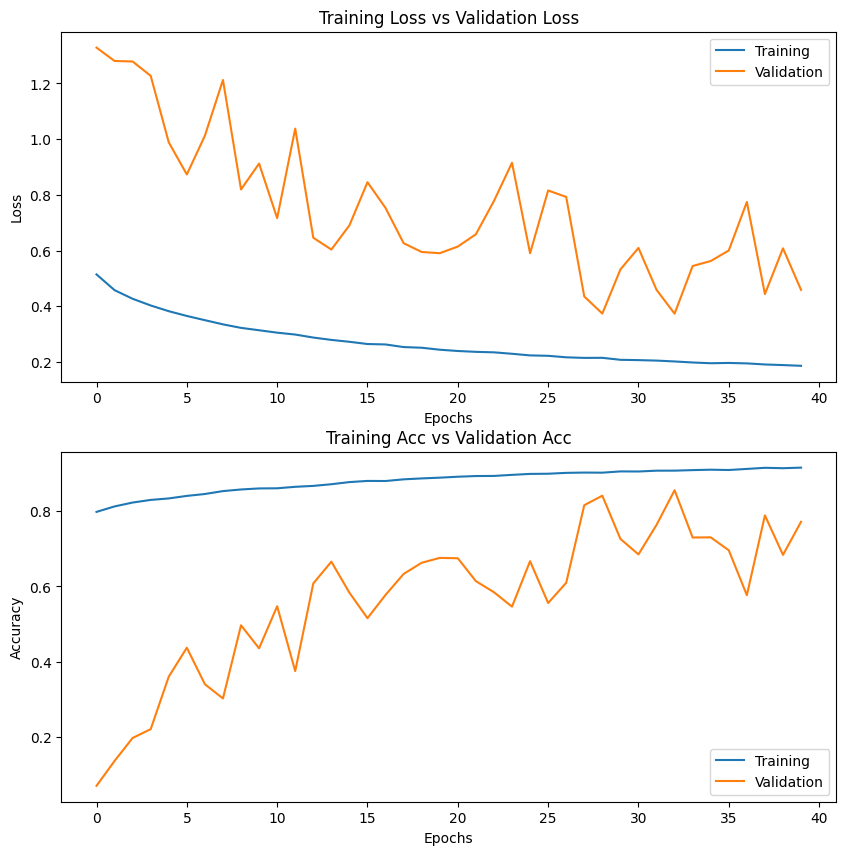

In [600]:
plot_train_val_loss_acc(history_b)

In [588]:
result_b_1 = model_b.evaluate(X_test, y_test)
result_b_1

215/215 [==============================] - 0s 547us/step - loss: 0.4489 - acc: 0.7815


[0.4489302635192871, 0.7815272808074951]

## Convolution, 1 feature (CHL)

### Model

In [591]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_32 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_28 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_33 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_17 (Flatten)        (None, 576)               0         
                                                                 
 dense_73 (Dense)            (None, 120)             

In [592]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [593]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 3s 8ms/step - loss: 0.5425 - acc: 0.7800 - val_loss: 1.3843 - val_acc: 0.0216
Epoch 2/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4818 - acc: 0.7954 - val_loss: 1.2771 - val_acc: 0.1258
Epoch 3/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4646 - acc: 0.8046 - val_loss: 1.2363 - val_acc: 0.1851
Epoch 4/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4534 - acc: 0.8131 - val_loss: 1.3996 - val_acc: 0.1738
Epoch 5/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4437 - acc: 0.8167 - val_loss: 1.2897 - val_acc: 0.2184
Epoch 6/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4337 - acc: 0.8194 - val_loss: 1.6074 - val_acc: 0.1376
Epoch 7/40
344/344 [==============================] - 3s 8ms/step - loss: 0.4242 - acc: 0.8216 - val_loss: 1.6154 - val_acc: 0.1291
Epoch 8/40
344/344 [==============================] - 3s 8ms/step - loss: 0.

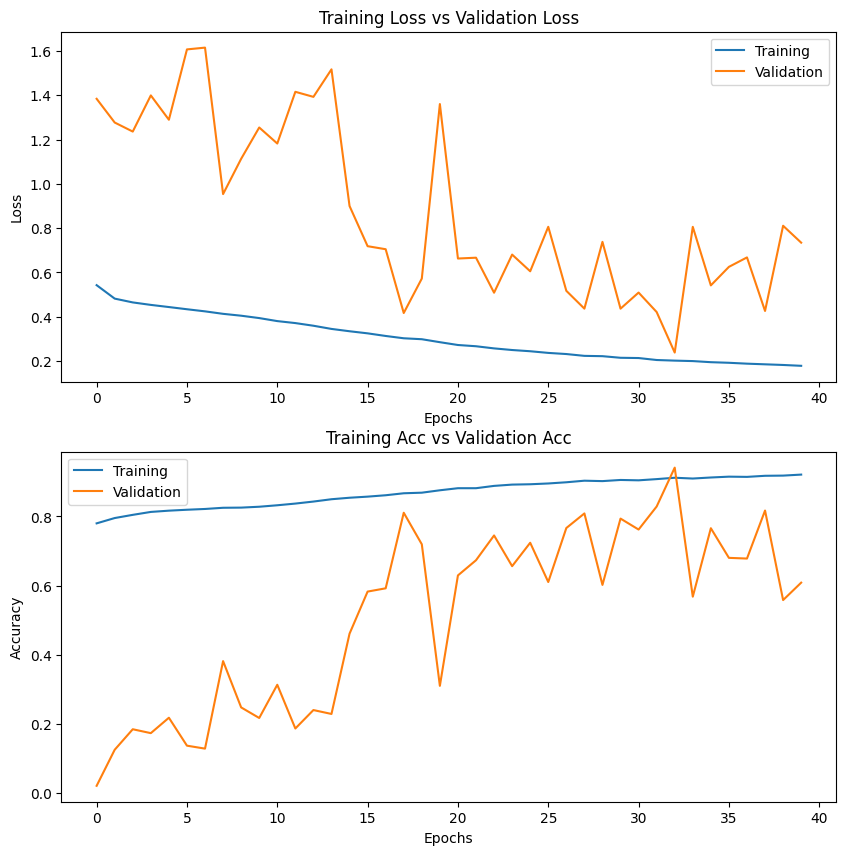

In [602]:
plot_train_val_loss_acc(history)

In [594]:
result_c_1 = model.evaluate(X_test, y_test)
result_c_1

215/215 [==============================] - 0s 2ms/step - loss: 0.7212 - acc: 0.6099


[0.7211840152740479, 0.6098909378051758]

## Baseline, 3 features

### Data

In [604]:
input_data_ = input_data[['TUR', 'SPM', 'CHL', 'riskLevelLabel']]

In [605]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(input_data_)

### Model

In [606]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_35 (Avera  (None, 16, 16, 3)        0         
 gePooling2D)                                                    
                                                                 
 flatten_19 (Flatten)        (None, 768)               0         
                                                                 
 dense_81 (Dense)            (None, 120)               92280     
                                                                 
 dense_82 (Dense)            (None, 84)                10164     
                                                                 
 dense_83 (Dense)            (None, 10)                850       
                                                                 
 dense_84 (Dense)            (None, 1)                 11        
                                                     

In [608]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [609]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 1s 2ms/step - loss: 0.5036 - acc: 0.8167 - val_loss: 1.0098 - val_acc: 0.3184
Epoch 2/40
344/344 [==============================] - 1s 2ms/step - loss: 0.3986 - acc: 0.8413 - val_loss: 0.9566 - val_acc: 0.3756
Epoch 3/40
344/344 [==============================] - 0s 1ms/step - loss: 0.3600 - acc: 0.8578 - val_loss: 0.8540 - val_acc: 0.4522
Epoch 4/40
344/344 [==============================] - 0s 1ms/step - loss: 0.3331 - acc: 0.8671 - val_loss: 0.8240 - val_acc: 0.5055
Epoch 5/40
344/344 [==============================] - 0s 1ms/step - loss: 0.3144 - acc: 0.8725 - val_loss: 0.7914 - val_acc: 0.5476
Epoch 6/40
344/344 [==============================] - 0s 1ms/step - loss: 0.2959 - acc: 0.8770 - val_loss: 0.9222 - val_acc: 0.4544
Epoch 7/40
344/344 [==============================] - 0s 1ms/step - loss: 0.2860 - acc: 0.8811 - val_loss: 0.7170 - val_acc: 0.6122
Epoch 8/40
344/344 [==============================] - 0s 1ms/step - loss: 0.

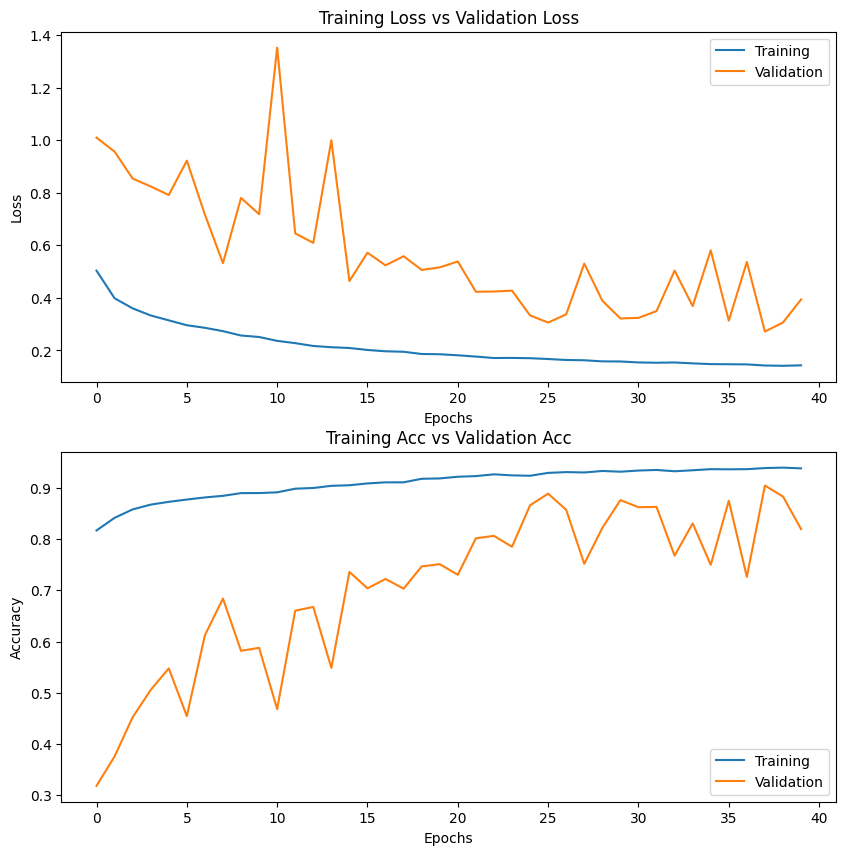

In [610]:
plot_train_val_loss_acc(history_b)

In [611]:
result_b_3 = model_b.evaluate(X_test, y_test)
result_b_3

215/215 [==============================] - 0s 675us/step - loss: 0.3914 - acc: 0.8192


[0.39139944314956665, 0.8191999793052673]

## Convolution, 3 features

### Model

In [613]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_36 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_37 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_20 (Flatten)        (None, 576)               0         
                                                                 
 dense_85 (Dense)            (None, 120)             

In [614]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [615]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 4s 11ms/step - loss: 0.5009 - acc: 0.8060 - val_loss: 1.1764 - val_acc: 0.1769
Epoch 2/40
344/344 [==============================] - 4s 10ms/step - loss: 0.4337 - acc: 0.8224 - val_loss: 1.0708 - val_acc: 0.3071
Epoch 3/40
344/344 [==============================] - 4s 10ms/step - loss: 0.4019 - acc: 0.8298 - val_loss: 0.8568 - val_acc: 0.4340
Epoch 4/40
344/344 [==============================] - 4s 10ms/step - loss: 0.3776 - acc: 0.8380 - val_loss: 1.1951 - val_acc: 0.3255
Epoch 5/40
344/344 [==============================] - 4s 10ms/step - loss: 0.3562 - acc: 0.8422 - val_loss: 1.0040 - val_acc: 0.3896
Epoch 6/40
344/344 [==============================] - 4s 10ms/step - loss: 0.3386 - acc: 0.8513 - val_loss: 1.0040 - val_acc: 0.3455
Epoch 7/40
344/344 [==============================] - 4s 10ms/step - loss: 0.3170 - acc: 0.8593 - val_loss: 0.6202 - val_acc: 0.6500
Epoch 8/40
344/344 [==============================] - 4s 10ms/step - 

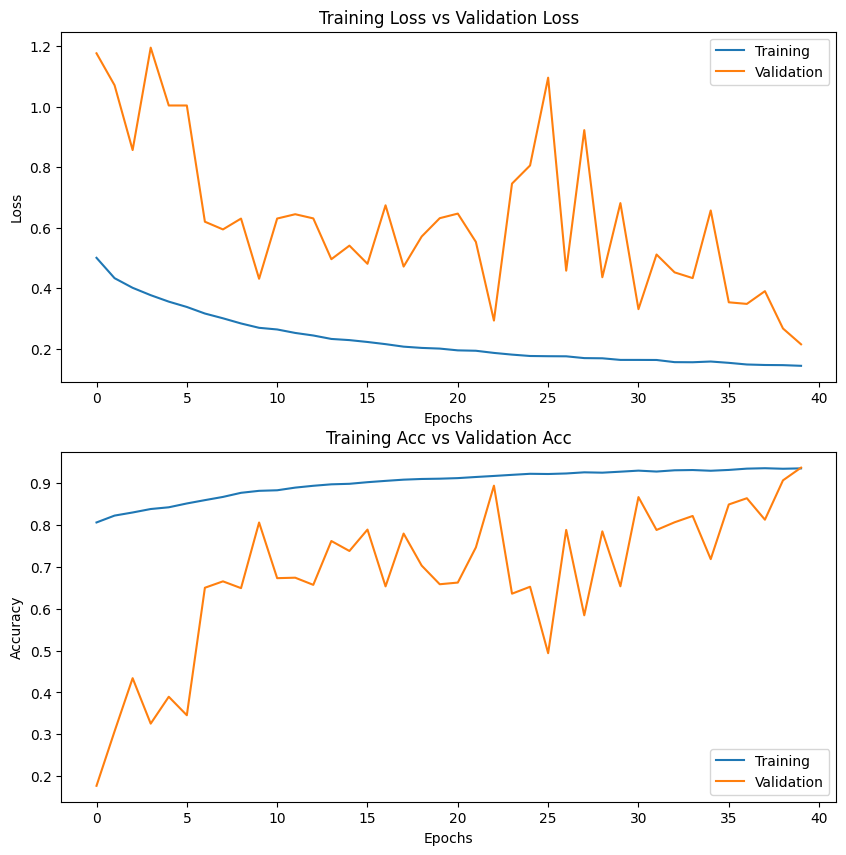

In [616]:
plot_train_val_loss_acc(history)

In [617]:
result_c_3 = model.evaluate(X_test, y_test)
result_c_3

215/215 [==============================] - 1s 2ms/step - loss: 0.2157 - acc: 0.9377


[0.21570466458797455, 0.9377454519271851]

### Result Summary

In [618]:
print('Baseline 1 Feature (CHL):', result_b_1)
print('Convolution 1 Feature (CHL):', result_c_1)
print('Baseline 3 Features:', result_b_3)
print('Convolution 3 Features:', result_c_3)

Baseline 1 Feature (CHL): [0.4489302635192871, 0.7815272808074951]
Convolution 1 Feature (CHL): [0.7211840152740479, 0.6098909378051758]
Baseline 3 Features: [0.39139944314956665, 0.8191999793052673]
Convolution 3 Features: [0.21570466458797455, 0.9377454519271851]
